In [43]:
from tqdm import tqdm
import requests
import pandas as pd
import os
from bs4 import BeautifulSoup
import time
from io import StringIO
import re

In [2]:
newest_gw = 3

In [143]:
fpl_players_path = f"C:/Users/erknud3/fpl-optimization/model/data/New_Season_Data/fpl_players_new_season_gw{newest_gw}.csv"

# Check if files exist
if not (
    os.path.exists(fpl_players_path)
):
    raise FileNotFoundError(
        f"One or more necessary files do not exist for gameweek {newest_gw}."
    )

fpl_players = pd.read_csv(fpl_players_path)

fpl_players = fpl_players[["fbref", "Player", "weighted_npxG", "weighted_xAG"]]

fpl_players["weighted_npxGI"] = fpl_players["weighted_npxG"] + fpl_players["weighted_xAG"]

fpl_players.dropna(subset=["weighted_npxGI"], inplace=True)

In [144]:
fpl_players = fpl_players.sort_values(by="weighted_npxGI", ascending=False)

In [145]:
# Initialize an empty list to store the URLs
player_urls = []

# Loop through each row in the DataFrame
for index, row in fpl_players.iterrows():
    fbref_id = row['fbref']
    player_name = row['Player']
    player_name_url = player_name.replace(' ', '-')
    url = f"https://fbref.com/en/players/{fbref_id}/{player_name_url}"
    player_urls.append(url)

# Output the list of URLs
print(player_urls)

['https://fbref.com/en/players/1f44ac21/Erling-Haaland', 'https://fbref.com/en/players/4d77b365/Darwin-Núñez', 'https://fbref.com/en/players/e342ad68/Mohamed-Salah', 'https://fbref.com/en/players/e46012d4/Kevin-De-Bruyne', 'https://fbref.com/en/players/dc7f8a28/Cole-Palmer', 'https://fbref.com/en/players/178ae8f8/Diogo-Jota', 'https://fbref.com/en/players/8450467d/Ali-Al-Hamadi', 'https://fbref.com/en/players/9c36ed83/Nicolas-Jackson', 'https://fbref.com/en/players/b66315ae/Gabriel-Jesus', 'https://fbref.com/en/players/d3d774cc/Marc-Guiu', 'https://fbref.com/en/players/4a1a9578/Luis-Díaz', 'https://fbref.com/en/players/9cfbad36/Julio-Enciso', 'https://fbref.com/en/players/8e92be30/Alexander-Isak', 'https://fbref.com/en/players/92e7e919/Son-Heung-min', 'https://fbref.com/en/players/aed3a70f/Ollie-Watkins', 'https://fbref.com/en/players/bc7dc64d/Bukayo-Saka', 'https://fbref.com/en/players/ed1e53f3/Phil-Foden', 'https://fbref.com/en/players/507c7bdf/Bruno-Fernandes', 'https://fbref.com/en

In [148]:
seasons = ['2023-2024', '2024-2025']

# Function to construct season links from player URL
def construct_season_links(player_url, seasons):
    # Extract the base part of the URL, player ID, and player name
    base_url = player_url.split('/players/')[0]
    fbref_id = player_url.split('/players/')[1].split('/')[0]
    player_name = player_url.split('/')[-1]
    
    # Construct the season URLs and return them as a single list
    return [
        f"{base_url}/players/{fbref_id}/matchlogs/{season}/summary/{player_name}-Match-Logs"
        for season in seasons
    ]

# Loop through each player URL and construct the season URLs, flattening the results directly
all_season_links = []
for url in player_urls:
    season_links = construct_season_links(url, seasons)
    all_season_links.extend(season_links)  # extend the list instead of appending
    #print(f'URL: {url}')
    #print('Constructed Season Links:', season_links)
    #print('---')
    

In [155]:
all_dfs = []

# Initialize the progress bar
with tqdm(total=len(all_season_links), desc="Processing URLs") as pbar:
    for url in all_season_links:
        try:
            data = requests.get(url)
            soup = BeautifulSoup(data.text, 'html.parser')
            ids = re.search(r'/players/([a-zA-Z0-9]{8})/', url)
            season = re.search(r'/(\d{4}-\d{4})/', url)

            table = soup.find("table", {"id": "matchlogs_all"})

            df = pd.read_html(StringIO(str(table)))[0]
            df.columns = [f"{i} {j}" if "Unnamed" not in i else j for i, j in df.columns]
            df = df[["Date", "Day", "Comp", "Round", "Venue", "Result", "Squad", "Opponent", "Start", "Pos", "Min"]]

            # Add fbref ID and season columns
            df["fbref"] = ids.group(1)
            df['Season'] = season.group(1)
            cols_to_move = ["fbref", "Season"]
            remaining_cols = [col for col in df.columns if col not in cols_to_move]
            new_order = remaining_cols[:1] + cols_to_move + remaining_cols[1:]
            
            df = df[new_order]
            df.dropna(inplace=True)
            #df = df[df['Comp'] == "Premier League"]

            # Append the DataFrame to the list
            all_dfs.append(df)

            # Sleep to avoid overloading the server
            time.sleep(12)

        except Exception as e:
            print(f"An error occurred for URL: {url}: {e}")

        # Update the progress bar
        pbar.update(1)

Processing URLs:  16%|█▋        | 115/704 [20:45<6:03:08, 36.99s/it]

An error occurred for URL: https://fbref.com/en/players/07802f7f/matchlogs/2023-2024/summary/Danny-Ings-Match-Logs: No tables found


Processing URLs:  19%|█▊        | 131/704 [24:04<1:09:31,  7.28s/it]

An error occurred for URL: https://fbref.com/en/players/99127249/matchlogs/2023-2024/summary/Antony-Match-Logs: No tables found


Processing URLs:  19%|█▉        | 132/704 [24:04<49:24,  5.18s/it]  

An error occurred for URL: https://fbref.com/en/players/99127249/matchlogs/2024-2025/summary/Antony-Match-Logs: No tables found


Processing URLs:  19%|█▉        | 133/704 [24:04<35:48,  3.76s/it]

An error occurred for URL: https://fbref.com/en/players/934e1968/matchlogs/2023-2024/summary/Dominik-Szoboszlai-Match-Logs: No tables found


Processing URLs:  19%|█▉        | 135/704 [24:14<37:39,  3.97s/it]

An error occurred for URL: https://fbref.com/en/players/9a28eba4/matchlogs/2023-2024/summary/Adama-Traoré-Match-Logs: No tables found


Processing URLs:  19%|█▉        | 137/704 [24:15<19:18,  2.04s/it]

An error occurred for URL: https://fbref.com/en/players/9a28eba4/matchlogs/2024-2025/summary/Adama-Traoré-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/819b3158/matchlogs/2023-2024/summary/İlkay-Gündoğan-Match-Logs: No tables found


Processing URLs:  20%|█▉        | 138/704 [24:15<14:02,  1.49s/it]

An error occurred for URL: https://fbref.com/en/players/819b3158/matchlogs/2024-2025/summary/İlkay-Gündoğan-Match-Logs: No tables found


Processing URLs:  20%|█▉        | 140/704 [24:15<07:46,  1.21it/s]

An error occurred for URL: https://fbref.com/en/players/6639e500/matchlogs/2023-2024/summary/Andreas-Pereira-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/6639e500/matchlogs/2024-2025/summary/Andreas-Pereira-Match-Logs: No tables found


Processing URLs:  20%|██        | 142/704 [24:16<04:32,  2.06it/s]

An error occurred for URL: https://fbref.com/en/players/32f60ed8/matchlogs/2023-2024/summary/Morgan-Gibbs-White-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/32f60ed8/matchlogs/2024-2025/summary/Morgan-Gibbs-White-Match-Logs: No tables found


Processing URLs:  20%|██        | 143/704 [24:16<03:34,  2.62it/s]

An error occurred for URL: https://fbref.com/en/players/b561db50/matchlogs/2023-2024/summary/Raúl-Jiménez-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/b561db50/matchlogs/2024-2025/summary/Raúl-Jiménez-Match-Logs: No tables found


Processing URLs:  21%|██        | 147/704 [24:16<01:52,  4.93it/s]

An error occurred for URL: https://fbref.com/en/players/2f9e4435/matchlogs/2023-2024/summary/Dango-Ouattara-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/2f9e4435/matchlogs/2024-2025/summary/Dango-Ouattara-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/df3cda47/matchlogs/2023-2024/summary/Dejan-Kulusevski-Match-Logs: No tables found


Processing URLs:  21%|██        | 149/704 [24:16<01:31,  6.05it/s]

An error occurred for URL: https://fbref.com/en/players/df3cda47/matchlogs/2024-2025/summary/Dejan-Kulusevski-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/e8832875/matchlogs/2023-2024/summary/João-Pedro-Match-Logs: No tables found


Processing URLs:  22%|██▏       | 152/704 [24:17<01:33,  5.92it/s]

An error occurred for URL: https://fbref.com/en/players/e8832875/matchlogs/2024-2025/summary/João-Pedro-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/0562b7f1/matchlogs/2023-2024/summary/Odsonne-Édouard-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/0562b7f1/matchlogs/2024-2025/summary/Odsonne-Édouard-Match-Logs: No tables found


Processing URLs:  22%|██▏       | 153/704 [24:17<01:26,  6.39it/s]

An error occurred for URL: https://fbref.com/en/players/05e8ca6d/matchlogs/2023-2024/summary/Cameron-Archer-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/05e8ca6d/matchlogs/2024-2025/summary/Cameron-Archer-Match-Logs: No tables found


Processing URLs:  22%|██▏       | 156/704 [24:17<01:13,  7.42it/s]

An error occurred for URL: https://fbref.com/en/players/a3b03921/matchlogs/2023-2024/summary/Joe-Willock-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/a3b03921/matchlogs/2024-2025/summary/Joe-Willock-Match-Logs: No tables found


Processing URLs:  22%|██▏       | 158/704 [24:18<01:10,  7.71it/s]

An error occurred for URL: https://fbref.com/en/players/169fd162/matchlogs/2023-2024/summary/Hwang-Hee-chan-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/169fd162/matchlogs/2024-2025/summary/Hwang-Hee-chan-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/37dc1a48/matchlogs/2023-2024/summary/Jesper-Lindstrøm-Match-Logs: No tables found


Processing URLs:  23%|██▎       | 162/704 [24:18<00:53, 10.13it/s]

An error occurred for URL: https://fbref.com/en/players/37dc1a48/matchlogs/2024-2025/summary/Jesper-Lindstrøm-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/3eb22ec9/matchlogs/2023-2024/summary/Bernardo-Silva-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/3eb22ec9/matchlogs/2024-2025/summary/Bernardo-Silva-Match-Logs: No tables found


Processing URLs:  23%|██▎       | 164/704 [24:18<01:03,  8.46it/s]

An error occurred for URL: https://fbref.com/en/players/52afb588/matchlogs/2023-2024/summary/Kevin-Schade-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/52afb588/matchlogs/2024-2025/summary/Kevin-Schade-Match-Logs: No tables found


Processing URLs:  24%|██▎       | 166/704 [24:19<01:05,  8.27it/s]

An error occurred for URL: https://fbref.com/en/players/4c3a6744/matchlogs/2023-2024/summary/Justin-Kluivert-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/4c3a6744/matchlogs/2024-2025/summary/Justin-Kluivert-Match-Logs: No tables found


Processing URLs:  24%|██▍       | 169/704 [24:19<01:02,  8.58it/s]

An error occurred for URL: https://fbref.com/en/players/03edb878/matchlogs/2023-2024/summary/Daniel-Jebbison-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/03edb878/matchlogs/2024-2025/summary/Daniel-Jebbison-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/fc15fb84/matchlogs/2023-2024/summary/Dwight-McNeil-Match-Logs: No tables found


Processing URLs:  24%|██▍       | 170/704 [24:19<01:00,  8.76it/s]

An error occurred for URL: https://fbref.com/en/players/fc15fb84/matchlogs/2024-2025/summary/Dwight-McNeil-Match-Logs: No tables found


Processing URLs:  24%|██▍       | 172/704 [24:19<01:14,  7.12it/s]

An error occurred for URL: https://fbref.com/en/players/fe6e7156/matchlogs/2023-2024/summary/Sávio-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/fe6e7156/matchlogs/2024-2025/summary/Sávio-Match-Logs: No tables found


Processing URLs:  25%|██▍       | 173/704 [24:19<01:12,  7.30it/s]

An error occurred for URL: https://fbref.com/en/players/b62878a5/matchlogs/2023-2024/summary/Mohammed-Kudus-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/b62878a5/matchlogs/2024-2025/summary/Mohammed-Kudus-Match-Logs: No tables found


Processing URLs:  25%|██▍       | 175/704 [24:20<01:09,  7.63it/s]

An error occurred for URL: https://fbref.com/en/players/980522ec/matchlogs/2023-2024/summary/Christian-Eriksen-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/980522ec/matchlogs/2024-2025/summary/Christian-Eriksen-Match-Logs: No tables found


Processing URLs:  25%|██▌       | 179/704 [24:20<01:02,  8.42it/s]

An error occurred for URL: https://fbref.com/en/players/028e70b9/matchlogs/2023-2024/summary/Joshua-Zirkzee-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/028e70b9/matchlogs/2024-2025/summary/Joshua-Zirkzee-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/41f08ac8/matchlogs/2023-2024/summary/Keane-Lewis-Potter-Match-Logs: No tables found


Processing URLs:  26%|██▌       | 182/704 [24:20<00:53,  9.70it/s]

An error occurred for URL: https://fbref.com/en/players/41f08ac8/matchlogs/2024-2025/summary/Keane-Lewis-Potter-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/efd2ec23/matchlogs/2023-2024/summary/Antoine-Semenyo-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/efd2ec23/matchlogs/2024-2025/summary/Antoine-Semenyo-Match-Logs: No tables found


Processing URLs:  26%|██▌       | 184/704 [24:21<00:51, 10.15it/s]

An error occurred for URL: https://fbref.com/en/players/4dcec659/matchlogs/2023-2024/summary/Simon-Adingra-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/4dcec659/matchlogs/2024-2025/summary/Simon-Adingra-Match-Logs: No tables found


Processing URLs:  26%|██▋       | 186/704 [24:21<00:51, 10.10it/s]

An error occurred for URL: https://fbref.com/en/players/f553b2b3/matchlogs/2023-2024/summary/Jørgen-Strand-Larsen-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/f553b2b3/matchlogs/2024-2025/summary/Jørgen-Strand-Larsen-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/27d0a506/matchlogs/2023-2024/summary/Pedro-Porro-Match-Logs: No tables found


Processing URLs:  27%|██▋       | 190/704 [24:21<00:57,  9.00it/s]

An error occurred for URL: https://fbref.com/en/players/27d0a506/matchlogs/2024-2025/summary/Pedro-Porro-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/9674002f/matchlogs/2023-2024/summary/Mason-Mount-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/9674002f/matchlogs/2024-2025/summary/Mason-Mount-Match-Logs: No tables found


Processing URLs:  27%|██▋       | 192/704 [24:22<00:56,  9.10it/s]

An error occurred for URL: https://fbref.com/en/players/862a1c15/matchlogs/2023-2024/summary/Miguel-Almirón-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/862a1c15/matchlogs/2024-2025/summary/Miguel-Almirón-Match-Logs: No tables found


Processing URLs:  28%|██▊       | 195/704 [24:22<00:57,  8.87it/s]

An error occurred for URL: https://fbref.com/en/players/5c0da4a4/matchlogs/2023-2024/summary/Marcus-Tavernier-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/5c0da4a4/matchlogs/2024-2025/summary/Marcus-Tavernier-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/c6dc9ecd/matchlogs/2023-2024/summary/Harry-Wilson-Match-Logs: No tables found


Processing URLs:  28%|██▊       | 198/704 [24:22<00:49, 10.23it/s]

An error occurred for URL: https://fbref.com/en/players/c6dc9ecd/matchlogs/2024-2025/summary/Harry-Wilson-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/7fcc71d8/matchlogs/2023-2024/summary/Daniel-Podence-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/7fcc71d8/matchlogs/2024-2025/summary/Daniel-Podence-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/c17bfb65/matchlogs/2023-2024/summary/Joelinton-Match-Logs: No tables found


Processing URLs:  28%|██▊       | 200/704 [24:22<00:45, 11.06it/s]

An error occurred for URL: https://fbref.com/en/players/c17bfb65/matchlogs/2024-2025/summary/Joelinton-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/02b29014/matchlogs/2023-2024/summary/Abdoulaye-Doucouré-Match-Logs: No tables found


Processing URLs:  29%|██▉       | 204/704 [24:23<00:42, 11.88it/s]

An error occurred for URL: https://fbref.com/en/players/02b29014/matchlogs/2024-2025/summary/Abdoulaye-Doucouré-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/3a24769f/matchlogs/2023-2024/summary/Ross-Barkley-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/3a24769f/matchlogs/2024-2025/summary/Ross-Barkley-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/1544f145/matchlogs/2023-2024/summary/Jacob-Ramsey-Match-Logs: No tables found


Processing URLs:  29%|██▉       | 206/704 [24:23<00:43, 11.48it/s]

An error occurred for URL: https://fbref.com/en/players/1544f145/matchlogs/2024-2025/summary/Jacob-Ramsey-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/aa849a12/matchlogs/2023-2024/summary/Jack-Harrison-Match-Logs: No tables found


Processing URLs:  30%|██▉       | 208/704 [24:23<00:54,  9.13it/s]

An error occurred for URL: https://fbref.com/en/players/aa849a12/matchlogs/2024-2025/summary/Jack-Harrison-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/c64c01fc/matchlogs/2023-2024/summary/Georginio-Rutter-Match-Logs: No tables found


Processing URLs:  30%|███       | 212/704 [24:24<00:47, 10.45it/s]

An error occurred for URL: https://fbref.com/en/players/c64c01fc/matchlogs/2024-2025/summary/Georginio-Rutter-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/de31038e/matchlogs/2023-2024/summary/Elliot-Anderson-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/de31038e/matchlogs/2024-2025/summary/Elliot-Anderson-Match-Logs: No tables found


Processing URLs:  30%|███       | 214/704 [24:24<00:46, 10.62it/s]

An error occurred for URL: https://fbref.com/en/players/68c720b5/matchlogs/2023-2024/summary/Adam-Armstrong-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/68c720b5/matchlogs/2024-2025/summary/Adam-Armstrong-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/6ca5ec4b/matchlogs/2023-2024/summary/Alex-Iwobi-Match-Logs: No tables found


Processing URLs:  31%|███       | 218/704 [24:24<00:46, 10.44it/s]

An error occurred for URL: https://fbref.com/en/players/6ca5ec4b/matchlogs/2024-2025/summary/Alex-Iwobi-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/468a7a91/matchlogs/2023-2024/summary/Facundo-Buonanotte-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/468a7a91/matchlogs/2024-2025/summary/Facundo-Buonanotte-Match-Logs: No tables found


Processing URLs:  31%|███▏      | 220/704 [24:24<00:40, 12.00it/s]

An error occurred for URL: https://fbref.com/en/players/21512407/matchlogs/2023-2024/summary/Kieran-Trippier-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/21512407/matchlogs/2024-2025/summary/Kieran-Trippier-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/8dcf77c0/matchlogs/2023-2024/summary/Rodrigo-Gomes-Match-Logs: No tables found


Processing URLs:  32%|███▏      | 224/704 [24:25<00:39, 12.31it/s]

An error occurred for URL: https://fbref.com/en/players/8dcf77c0/matchlogs/2024-2025/summary/Rodrigo-Gomes-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/2e4f5f03/matchlogs/2023-2024/summary/Andrew-Robertson-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/2e4f5f03/matchlogs/2024-2025/summary/Andrew-Robertson-Match-Logs: No tables found


Processing URLs:  32%|███▏      | 226/704 [24:25<00:38, 12.35it/s]

An error occurred for URL: https://fbref.com/en/players/df04eb4b/matchlogs/2023-2024/summary/Crysencio-Summerville-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/df04eb4b/matchlogs/2024-2025/summary/Crysencio-Summerville-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/57827369/matchlogs/2023-2024/summary/Ben-Brereton-Match-Logs: No tables found


Processing URLs:  32%|███▏      | 228/704 [24:25<00:36, 12.89it/s]

An error occurred for URL: https://fbref.com/en/players/57827369/matchlogs/2024-2025/summary/Ben-Brereton-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/5ff4ab71/matchlogs/2023-2024/summary/Enzo-Fernández-Match-Logs: No tables found


Processing URLs:  33%|███▎      | 232/704 [24:25<00:41, 11.27it/s]

An error occurred for URL: https://fbref.com/en/players/5ff4ab71/matchlogs/2024-2025/summary/Enzo-Fernández-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/3515d404/matchlogs/2023-2024/summary/James-Ward-Prowse-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/3515d404/matchlogs/2024-2025/summary/James-Ward-Prowse-Match-Logs: No tables found


Processing URLs:  33%|███▎      | 234/704 [24:25<00:40, 11.65it/s]

An error occurred for URL: https://fbref.com/en/players/9b6f7fd5/matchlogs/2023-2024/summary/Lucas-Paquetá-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/9b6f7fd5/matchlogs/2024-2025/summary/Lucas-Paquetá-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/215f3907/matchlogs/2023-2024/summary/Mikkel-Damsgaard-Match-Logs: No tables found


Processing URLs:  34%|███▍      | 238/704 [24:26<00:37, 12.54it/s]

An error occurred for URL: https://fbref.com/en/players/215f3907/matchlogs/2024-2025/summary/Mikkel-Damsgaard-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/2e5915f1/matchlogs/2023-2024/summary/Morgan-Rogers-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/2e5915f1/matchlogs/2024-2025/summary/Morgan-Rogers-Match-Logs: No tables found


Processing URLs:  34%|███▍      | 240/704 [24:26<00:39, 11.72it/s]

An error occurred for URL: https://fbref.com/en/players/bbd67769/matchlogs/2023-2024/summary/Conor-Bradley-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/bbd67769/matchlogs/2024-2025/summary/Conor-Bradley-Match-Logs: No tables found


Processing URLs:  34%|███▍      | 242/704 [24:26<00:45, 10.22it/s]

An error occurred for URL: https://fbref.com/en/players/0f7533cd/matchlogs/2023-2024/summary/Bobby-Reid-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/0f7533cd/matchlogs/2024-2025/summary/Bobby-Reid-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/d328a254/matchlogs/2023-2024/summary/Philip-Billing-Match-Logs: No tables found


Processing URLs:  35%|███▍      | 246/704 [24:27<00:41, 11.05it/s]

An error occurred for URL: https://fbref.com/en/players/d328a254/matchlogs/2024-2025/summary/Philip-Billing-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/82518f62/matchlogs/2023-2024/summary/Bruno-Guimarães-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/82518f62/matchlogs/2024-2025/summary/Bruno-Guimarães-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/15f3ec41/matchlogs/2023-2024/summary/Callum-Hudson-Odoi-Match-Logs: No tables found


Processing URLs:  36%|███▌      | 251/704 [24:27<00:32, 13.99it/s]

An error occurred for URL: https://fbref.com/en/players/15f3ec41/matchlogs/2024-2025/summary/Callum-Hudson-Odoi-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/83d074ff/matchlogs/2023-2024/summary/Alexis-Mac-Allister-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/83d074ff/matchlogs/2024-2025/summary/Alexis-Mac-Allister-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/bceda5ff/matchlogs/2023-2024/summary/Abdul-Fatawu-Issahaku-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/bceda5ff/matchlogs/2024-2025/summary/Abdul-Fatawu-Issahaku-Match-Logs: No tables found


Processing URLs:  36%|███▌      | 255/704 [24:27<00:29, 15.21it/s]

An error occurred for URL: https://fbref.com/en/players/dc6c2f02/matchlogs/2023-2024/summary/Chiquinho-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/dc6c2f02/matchlogs/2024-2025/summary/Chiquinho-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/da052c14/matchlogs/2023-2024/summary/Jordan-Ayew-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/da052c14/matchlogs/2024-2025/summary/Jordan-Ayew-Match-Logs: No tables found


Processing URLs:  37%|███▋      | 259/704 [24:27<00:30, 14.79it/s]

An error occurred for URL: https://fbref.com/en/players/788c0277/matchlogs/2023-2024/summary/Chiedozie-Ogbene-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/788c0277/matchlogs/2024-2025/summary/Chiedozie-Ogbene-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/bfdb33aa/matchlogs/2023-2024/summary/Ismaila-Sarr-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/bfdb33aa/matchlogs/2024-2025/summary/Ismaila-Sarr-Match-Logs: No tables found


Processing URLs:  37%|███▋      | 263/704 [24:28<00:31, 14.19it/s]

An error occurred for URL: https://fbref.com/en/players/9dc96f10/matchlogs/2023-2024/summary/Amad-Diallo-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/9dc96f10/matchlogs/2024-2025/summary/Amad-Diallo-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/e6bc67d7/matchlogs/2023-2024/summary/Gonçalo-Guedes-Match-Logs: No tables found


Processing URLs:  38%|███▊      | 265/704 [24:28<00:31, 13.93it/s]

An error occurred for URL: https://fbref.com/en/players/e6bc67d7/matchlogs/2024-2025/summary/Gonçalo-Guedes-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/5c74c0f5/matchlogs/2023-2024/summary/Kiernan-Dewsbury-Hall-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/5c74c0f5/matchlogs/2024-2025/summary/Kiernan-Dewsbury-Hall-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/96593e89/matchlogs/2023-2024/summary/James-Mcatee-Match-Logs: No tables found


Processing URLs:  38%|███▊      | 269/704 [24:28<00:41, 10.58it/s]

An error occurred for URL: https://fbref.com/en/players/96593e89/matchlogs/2024-2025/summary/James-Mcatee-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/15b287da/matchlogs/2023-2024/summary/Daichi-Kamada-Match-Logs: No tables found


Processing URLs:  38%|███▊      | 271/704 [24:28<00:42, 10.09it/s]

An error occurred for URL: https://fbref.com/en/players/15b287da/matchlogs/2024-2025/summary/Daichi-Kamada-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/5ed97752/matchlogs/2023-2024/summary/Iliman-Ndiaye-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/5ed97752/matchlogs/2024-2025/summary/Iliman-Ndiaye-Match-Logs: No tables found


Processing URLs:  39%|███▉      | 275/704 [24:29<00:40, 10.71it/s]

An error occurred for URL: https://fbref.com/en/players/b2c66859/matchlogs/2023-2024/summary/Kasey-McAteer-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/b2c66859/matchlogs/2024-2025/summary/Kasey-McAteer-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/6613c819/matchlogs/2023-2024/summary/Tomáš-Souček-Match-Logs: No tables found


Processing URLs:  40%|███▉      | 279/704 [24:29<00:37, 11.23it/s]

An error occurred for URL: https://fbref.com/en/players/6613c819/matchlogs/2024-2025/summary/Tomáš-Souček-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/d38fdf53/matchlogs/2023-2024/summary/Pervis-Estupiñán-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/d38fdf53/matchlogs/2024-2025/summary/Pervis-Estupiñán-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/a2b105e0/matchlogs/2023-2024/summary/Sean-Longstaff-Match-Logs: No tables found


Processing URLs:  40%|████      | 283/704 [24:29<00:31, 13.35it/s]

An error occurred for URL: https://fbref.com/en/players/a2b105e0/matchlogs/2024-2025/summary/Sean-Longstaff-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/2944f86f/matchlogs/2023-2024/summary/Frank-Onyeka-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/2944f86f/matchlogs/2024-2025/summary/Frank-Onyeka-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/e98211e7/matchlogs/2023-2024/summary/Jack-Hinshelwood-Match-Logs: No tables found


Processing URLs:  41%|████      | 287/704 [24:30<00:26, 15.50it/s]

An error occurred for URL: https://fbref.com/en/players/e98211e7/matchlogs/2024-2025/summary/Jack-Hinshelwood-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/30144daa/matchlogs/2023-2024/summary/Stephy-Mavididi-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/30144daa/matchlogs/2024-2025/summary/Stephy-Mavididi-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/f173303a/matchlogs/2023-2024/summary/Yasin-Ayari-Match-Logs: No tables found


Processing URLs:  41%|████      | 289/704 [24:30<00:25, 16.08it/s]

An error occurred for URL: https://fbref.com/en/players/f173303a/matchlogs/2024-2025/summary/Yasin-Ayari-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/90f91999/matchlogs/2023-2024/summary/John-McGinn-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/90f91999/matchlogs/2024-2025/summary/John-McGinn-Match-Logs: No tables found


Processing URLs:  41%|████▏     | 291/704 [24:30<00:28, 14.54it/s]

An error occurred for URL: https://fbref.com/en/players/4ec55b87/matchlogs/2023-2024/summary/Conor-Chaplin-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/4ec55b87/matchlogs/2024-2025/summary/Conor-Chaplin-Match-Logs: No tables found


Processing URLs:  42%|████▏     | 295/704 [24:30<00:34, 11.84it/s]

An error occurred for URL: https://fbref.com/en/players/26ce2263/matchlogs/2023-2024/summary/Ryan-Christie-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/26ce2263/matchlogs/2024-2025/summary/Ryan-Christie-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/56f7a928/matchlogs/2023-2024/summary/Youri-Tielemans-Match-Logs: No tables found


Processing URLs:  42%|████▏     | 297/704 [24:30<00:34, 11.87it/s]

An error occurred for URL: https://fbref.com/en/players/56f7a928/matchlogs/2024-2025/summary/Youri-Tielemans-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/4d224fe8/matchlogs/2023-2024/summary/Casemiro-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/4d224fe8/matchlogs/2024-2025/summary/Casemiro-Match-Logs: No tables found


Processing URLs:  43%|████▎     | 301/704 [24:31<00:29, 13.67it/s]

An error occurred for URL: https://fbref.com/en/players/0f134faf/matchlogs/2023-2024/summary/Mathias-Jensen-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/0f134faf/matchlogs/2024-2025/summary/Mathias-Jensen-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/d93c2511/matchlogs/2023-2024/summary/Scott-McTominay-Match-Logs: No tables found


Processing URLs:  43%|████▎     | 305/704 [24:31<00:29, 13.74it/s]

An error occurred for URL: https://fbref.com/en/players/d93c2511/matchlogs/2024-2025/summary/Scott-McTominay-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/35516eac/matchlogs/2023-2024/summary/Wilson-Odobert-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/35516eac/matchlogs/2024-2025/summary/Wilson-Odobert-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/9eedf0e0/matchlogs/2023-2024/summary/Samuel-Amo-Ameyaw-Match-Logs: No tables found


Processing URLs:  44%|████▎     | 307/704 [24:31<00:31, 12.67it/s]

An error occurred for URL: https://fbref.com/en/players/9eedf0e0/matchlogs/2024-2025/summary/Samuel-Amo-Ameyaw-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/2f90f6b8/matchlogs/2023-2024/summary/James-Milner-Match-Logs: No tables found


Processing URLs:  44%|████▍     | 311/704 [24:32<00:38, 10.24it/s]

An error occurred for URL: https://fbref.com/en/players/2f90f6b8/matchlogs/2024-2025/summary/James-Milner-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/b3fe23c6/matchlogs/2023-2024/summary/Wes-Burns-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/b3fe23c6/matchlogs/2024-2025/summary/Wes-Burns-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/99813635/matchlogs/2023-2024/summary/Adam-Lallana-Match-Logs: No tables found


Processing URLs:  44%|████▍     | 313/704 [24:32<00:35, 11.05it/s]

An error occurred for URL: https://fbref.com/en/players/99813635/matchlogs/2024-2025/summary/Adam-Lallana-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/828657ff/matchlogs/2023-2024/summary/Amadou-Onana-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/828657ff/matchlogs/2024-2025/summary/Amadou-Onana-Match-Logs: No tables found


Processing URLs:  45%|████▌     | 317/704 [24:32<00:37, 10.43it/s]

An error occurred for URL: https://fbref.com/en/players/10f0fdd3/matchlogs/2023-2024/summary/Jean-Ricner-Bellegarde-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/10f0fdd3/matchlogs/2024-2025/summary/Jean-Ricner-Bellegarde-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/966e28d0/matchlogs/2023-2024/summary/Fabio-Carvalho-Match-Logs: No tables found


Processing URLs:  46%|████▌     | 321/704 [24:33<00:31, 12.31it/s]

An error occurred for URL: https://fbref.com/en/players/966e28d0/matchlogs/2024-2025/summary/Fabio-Carvalho-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/0db169ae/matchlogs/2023-2024/summary/Sandro-Tonali-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/0db169ae/matchlogs/2024-2025/summary/Sandro-Tonali-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/778ef829/matchlogs/2023-2024/summary/Daniel-Muñoz-Match-Logs: No tables found


Processing URLs:  46%|████▌     | 325/704 [24:33<00:27, 13.54it/s]

An error occurred for URL: https://fbref.com/en/players/778ef829/matchlogs/2024-2025/summary/Daniel-Muñoz-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/df0a4c90/matchlogs/2023-2024/summary/Christian-Nørgaard-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/df0a4c90/matchlogs/2024-2025/summary/Christian-Nørgaard-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/a8748947/matchlogs/2023-2024/summary/Tom-Cairney-Match-Logs: No tables found


Processing URLs:  46%|████▋     | 327/704 [24:33<00:49,  7.56it/s]

An error occurred for URL: https://fbref.com/en/players/a8748947/matchlogs/2024-2025/summary/Tom-Cairney-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/9b398aea/matchlogs/2023-2024/summary/Rayan-Aït-Nouri-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/9b398aea/matchlogs/2024-2025/summary/Rayan-Aït-Nouri-Match-Logs: No tables found


Processing URLs:  47%|████▋     | 331/704 [24:34<00:40,  9.11it/s]

An error occurred for URL: https://fbref.com/en/players/3312f911/matchlogs/2023-2024/summary/Jeffrey-Schlupp-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/3312f911/matchlogs/2024-2025/summary/Jeffrey-Schlupp-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/feb5d972/matchlogs/2023-2024/summary/Pape-Matar-Sarr-Match-Logs: No tables found


Processing URLs:  47%|████▋     | 333/704 [24:34<00:37,  9.82it/s]

An error occurred for URL: https://fbref.com/en/players/feb5d972/matchlogs/2024-2025/summary/Pape-Matar-Sarr-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/b57e066e/matchlogs/2023-2024/summary/Rico-Lewis-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/b57e066e/matchlogs/2024-2025/summary/Rico-Lewis-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/f315ca93/matchlogs/2023-2024/summary/Kostas-Tsimikas-Match-Logs: No tables found


Processing URLs:  48%|████▊     | 336/704 [24:34<00:30, 12.01it/s]

An error occurred for URL: https://fbref.com/en/players/f315ca93/matchlogs/2024-2025/summary/Kostas-Tsimikas-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/3b8674e6/matchlogs/2023-2024/summary/Rodrigo-Bentancur-Match-Logs: No tables found


Processing URLs:  48%|████▊     | 340/704 [24:34<00:33, 10.85it/s]

An error occurred for URL: https://fbref.com/en/players/3b8674e6/matchlogs/2024-2025/summary/Rodrigo-Bentancur-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/e6af02e0/matchlogs/2023-2024/summary/Matheus-Nunes-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/e6af02e0/matchlogs/2024-2025/summary/Matheus-Nunes-Match-Logs: No tables found


Processing URLs:  49%|████▊     | 342/704 [24:35<00:29, 12.21it/s]

An error occurred for URL: https://fbref.com/en/players/d56b9520/matchlogs/2023-2024/summary/Malo-Gusto-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/d56b9520/matchlogs/2024-2025/summary/Malo-Gusto-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/bd9553e6/matchlogs/2023-2024/summary/Omari-Hutchinson-Match-Logs: No tables found


Processing URLs:  49%|████▉     | 346/704 [24:35<00:37,  9.47it/s]

An error occurred for URL: https://fbref.com/en/players/bd9553e6/matchlogs/2024-2025/summary/Omari-Hutchinson-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/d557d734/matchlogs/2023-2024/summary/Matt-Doherty-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/d557d734/matchlogs/2024-2025/summary/Matt-Doherty-Match-Logs: No tables found


Processing URLs:  49%|████▉     | 348/704 [24:35<00:33, 10.60it/s]

An error occurred for URL: https://fbref.com/en/players/dd897ee7/matchlogs/2023-2024/summary/Liam-Delap-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/dd897ee7/matchlogs/2024-2025/summary/Liam-Delap-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/2389cdc2/matchlogs/2023-2024/summary/Matty-Cash-Match-Logs: No tables found


Processing URLs:  50%|█████     | 352/704 [24:36<00:28, 12.33it/s]

An error occurred for URL: https://fbref.com/en/players/2389cdc2/matchlogs/2024-2025/summary/Matty-Cash-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/4abac767/matchlogs/2023-2024/summary/Carlos-Alcaraz-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/4abac767/matchlogs/2024-2025/summary/Carlos-Alcaraz-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/b2626673/matchlogs/2023-2024/summary/Jay-Stansfield-Match-Logs: No tables found


Processing URLs:  51%|█████     | 356/704 [24:36<00:23, 14.71it/s]

An error occurred for URL: https://fbref.com/en/players/b2626673/matchlogs/2024-2025/summary/Jay-Stansfield-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/da011f18/matchlogs/2023-2024/summary/Lewis-Hall-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/da011f18/matchlogs/2024-2025/summary/Lewis-Hall-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/79c0821a/matchlogs/2023-2024/summary/Mateo-Kovačić-Match-Logs: No tables found


Processing URLs:  51%|█████     | 360/704 [24:36<00:33, 10.35it/s]

An error occurred for URL: https://fbref.com/en/players/79c0821a/matchlogs/2024-2025/summary/Mateo-Kovačić-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/b8e740fb/matchlogs/2023-2024/summary/Ryan-Gravenberch-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/b8e740fb/matchlogs/2024-2025/summary/Ryan-Gravenberch-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/007414dd/matchlogs/2023-2024/summary/Samuel-Edozie-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/007414dd/matchlogs/2024-2025/summary/Samuel-Edozie-Match-Logs: No tables found


Processing URLs:  52%|█████▏    | 366/704 [24:37<00:25, 13.49it/s]

An error occurred for URL: https://fbref.com/en/players/19f4d211/matchlogs/2023-2024/summary/Jaden-Philogene-Bidace-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/19f4d211/matchlogs/2024-2025/summary/Jaden-Philogene-Bidace-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/a816dbfb/matchlogs/2023-2024/summary/Danilo-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/a816dbfb/matchlogs/2024-2025/summary/Danilo-Match-Logs: No tables found


Processing URLs:  53%|█████▎    | 370/704 [24:37<00:23, 14.06it/s]

An error occurred for URL: https://fbref.com/en/players/e16932d8/matchlogs/2023-2024/summary/Jack-Clarke-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/e16932d8/matchlogs/2024-2025/summary/Jack-Clarke-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/8449d35e/matchlogs/2023-2024/summary/Vitaly-Janelt-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/8449d35e/matchlogs/2024-2025/summary/Vitaly-Janelt-Match-Logs: No tables found


Processing URLs:  53%|█████▎    | 372/704 [24:37<00:25, 13.10it/s]

An error occurred for URL: https://fbref.com/en/players/7cd520e8/matchlogs/2023-2024/summary/Destiny-Udogie-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/7cd520e8/matchlogs/2024-2025/summary/Destiny-Udogie-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/1b84dbe1/matchlogs/2023-2024/summary/Lucas-Digne-Match-Logs: No tables found


Processing URLs:  53%|█████▎    | 374/704 [24:37<00:23, 14.28it/s]

An error occurred for URL: https://fbref.com/en/players/1b84dbe1/matchlogs/2024-2025/summary/Lucas-Digne-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/328f7d51/matchlogs/2023-2024/summary/Joe-Aribo-Match-Logs: No tables found


Processing URLs:  54%|█████▎    | 378/704 [24:38<00:29, 11.22it/s]

An error occurred for URL: https://fbref.com/en/players/328f7d51/matchlogs/2024-2025/summary/Joe-Aribo-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/1c7012b8/matchlogs/2023-2024/summary/Declan-Rice-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/1c7012b8/matchlogs/2024-2025/summary/Declan-Rice-Match-Logs: No tables found


Processing URLs:  54%|█████▍    | 380/704 [24:38<00:25, 12.74it/s]

An error occurred for URL: https://fbref.com/en/players/90e9ca3d/matchlogs/2023-2024/summary/Marcus-Harness-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/90e9ca3d/matchlogs/2024-2025/summary/Marcus-Harness-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/9b5ce51a/matchlogs/2023-2024/summary/Jefferson-Lerma-Match-Logs: No tables found


Processing URLs:  55%|█████▍    | 384/704 [24:38<00:23, 13.76it/s]

An error occurred for URL: https://fbref.com/en/players/9b5ce51a/matchlogs/2024-2025/summary/Jefferson-Lerma-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/c149016b/matchlogs/2023-2024/summary/Wataru-Endo-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/c149016b/matchlogs/2024-2025/summary/Wataru-Endo-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/ac0d576d/matchlogs/2023-2024/summary/Jeremy-Sarmiento-Match-Logs: No tables found


Processing URLs:  55%|█████▍    | 386/704 [24:38<00:26, 11.94it/s]

An error occurred for URL: https://fbref.com/en/players/ac0d576d/matchlogs/2024-2025/summary/Jeremy-Sarmiento-Match-Logs: No tables found


Processing URLs:  55%|█████▌    | 390/704 [24:40<00:55,  5.67it/s]

An error occurred for URL: https://fbref.com/en/players/a105d46a/matchlogs/2023-2024/summary/Harry-Toffolo-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/a105d46a/matchlogs/2024-2025/summary/Harry-Toffolo-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/c6e8cf1f/matchlogs/2023-2024/summary/Saša-Lukić-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/c6e8cf1f/matchlogs/2024-2025/summary/Saša-Lukić-Match-Logs: No tables found


Processing URLs:  56%|█████▌    | 394/704 [24:40<00:35,  8.70it/s]

An error occurred for URL: https://fbref.com/en/players/51cf8561/matchlogs/2023-2024/summary/Oleksandr-Zinchenko-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/51cf8561/matchlogs/2024-2025/summary/Oleksandr-Zinchenko-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/c1fe2a48/matchlogs/2023-2024/summary/Ryan-Yates-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/c1fe2a48/matchlogs/2024-2025/summary/Ryan-Yates-Match-Logs: No tables found


Processing URLs:  56%|█████▋    | 396/704 [24:40<00:29, 10.39it/s]

An error occurred for URL: https://fbref.com/en/players/8574c61f/matchlogs/2023-2024/summary/Leif-Davis-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/8574c61f/matchlogs/2024-2025/summary/Leif-Davis-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/580bcd18/matchlogs/2023-2024/summary/Yukinari-Sugawara-Match-Logs: No tables found


Processing URLs:  57%|█████▋    | 398/704 [24:40<00:28, 10.83it/s]

An error occurred for URL: https://fbref.com/en/players/580bcd18/matchlogs/2024-2025/summary/Yukinari-Sugawara-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/eaeca114/matchlogs/2023-2024/summary/Nathan-Aké-Match-Logs: No tables found


Processing URLs:  57%|█████▋    | 402/704 [24:40<00:28, 10.66it/s]

An error occurred for URL: https://fbref.com/en/players/eaeca114/matchlogs/2024-2025/summary/Nathan-Aké-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/d9565625/matchlogs/2023-2024/summary/Diogo-Dalot-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/d9565625/matchlogs/2024-2025/summary/Diogo-Dalot-Match-Logs: No tables found


Processing URLs:  57%|█████▋    | 404/704 [24:41<00:28, 10.43it/s]

An error occurred for URL: https://fbref.com/en/players/4876c9ab/matchlogs/2023-2024/summary/Mats-Wieffer-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/4876c9ab/matchlogs/2024-2025/summary/Mats-Wieffer-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/dd323728/matchlogs/2023-2024/summary/Neco-Williams-Match-Logs: No tables found


Processing URLs:  58%|█████▊    | 408/704 [24:41<00:26, 11.00it/s]

An error occurred for URL: https://fbref.com/en/players/dd323728/matchlogs/2024-2025/summary/Neco-Williams-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/8df7a2fb/matchlogs/2023-2024/summary/Ben-Mee-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/8df7a2fb/matchlogs/2024-2025/summary/Ben-Mee-Match-Logs: No tables found


Processing URLs:  59%|█████▊    | 412/704 [24:41<00:22, 13.24it/s]

An error occurred for URL: https://fbref.com/en/players/c8aa95da/matchlogs/2023-2024/summary/Fabian-Schär-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/c8aa95da/matchlogs/2024-2025/summary/Fabian-Schär-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/2b471f99/matchlogs/2023-2024/summary/Mario-Lemina-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/2b471f99/matchlogs/2024-2025/summary/Mario-Lemina-Match-Logs: No tables found


Processing URLs:  59%|█████▉    | 414/704 [24:41<00:21, 13.23it/s]

An error occurred for URL: https://fbref.com/en/players/a8c0acb7/matchlogs/2023-2024/summary/Kristoffer-Ajer-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/a8c0acb7/matchlogs/2024-2025/summary/Kristoffer-Ajer-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/c5b7c315/matchlogs/2023-2024/summary/Michael-Keane-Match-Logs: No tables found


Processing URLs:  59%|█████▉    | 418/704 [24:42<00:19, 14.88it/s]

An error occurred for URL: https://fbref.com/en/players/c5b7c315/matchlogs/2024-2025/summary/Michael-Keane-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/5e105217/matchlogs/2023-2024/summary/William-Smallbone-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/5e105217/matchlogs/2024-2025/summary/William-Smallbone-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/20b3a502/matchlogs/2023-2024/summary/Nicolás-Domínguez-Match-Logs: No tables found


Processing URLs:  60%|█████▉    | 422/704 [24:42<00:17, 16.00it/s]

An error occurred for URL: https://fbref.com/en/players/20b3a502/matchlogs/2024-2025/summary/Nicolás-Domínguez-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/5ad50391/matchlogs/2023-2024/summary/Joško-Gvardiol-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/5ad50391/matchlogs/2024-2025/summary/Joško-Gvardiol-Match-Logs: No tables found


Processing URLs:  61%|██████    | 426/704 [24:42<00:20, 13.62it/s]

An error occurred for URL: https://fbref.com/en/players/d0b6129f/matchlogs/2023-2024/summary/Sander-Berge-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/d0b6129f/matchlogs/2024-2025/summary/Sander-Berge-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/4f974391/matchlogs/2023-2024/summary/Aaron-Cresswell-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/4f974391/matchlogs/2024-2025/summary/Aaron-Cresswell-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/67ac5bb8/matchlogs/2023-2024/summary/Gabriel-Magalhães-Match-Logs: No tables found


Processing URLs:  61%|██████    | 430/704 [24:43<00:24, 11.25it/s]

An error occurred for URL: https://fbref.com/en/players/67ac5bb8/matchlogs/2024-2025/summary/Gabriel-Magalhães-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/529f49ab/matchlogs/2023-2024/summary/Thomas-Partey-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/529f49ab/matchlogs/2024-2025/summary/Thomas-Partey-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/d8931174/matchlogs/2023-2024/summary/Harry-Maguire-Match-Logs: No tables found


Processing URLs:  62%|██████▏   | 434/704 [24:43<00:20, 13.50it/s]

An error occurred for URL: https://fbref.com/en/players/d8931174/matchlogs/2024-2025/summary/Harry-Maguire-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/2afc7272/matchlogs/2023-2024/summary/Lewis-Cook-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/2afc7272/matchlogs/2024-2025/summary/Lewis-Cook-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/df10e27c/matchlogs/2023-2024/summary/Billy-Gilmour-Match-Logs: No tables found


Processing URLs:  62%|██████▏   | 438/704 [24:43<00:21, 12.31it/s]

An error occurred for URL: https://fbref.com/en/players/df10e27c/matchlogs/2024-2025/summary/Billy-Gilmour-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/15ea812b/matchlogs/2023-2024/summary/James-Tarkowski-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/15ea812b/matchlogs/2024-2025/summary/James-Tarkowski-Match-Logs: No tables found


Processing URLs:  62%|██████▎   | 440/704 [24:43<00:20, 12.59it/s]

An error occurred for URL: https://fbref.com/en/players/4b542852/matchlogs/2023-2024/summary/Adam-Wharton-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/4b542852/matchlogs/2024-2025/summary/Adam-Wharton-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/803ae100/matchlogs/2023-2024/summary/Harrison-Reed-Match-Logs: No tables found


Processing URLs:  63%|██████▎   | 444/704 [24:44<00:19, 13.42it/s]

An error occurred for URL: https://fbref.com/en/players/803ae100/matchlogs/2024-2025/summary/Harrison-Reed-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/cab9634e/matchlogs/2023-2024/summary/Ian-Maatsen-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/cab9634e/matchlogs/2024-2025/summary/Ian-Maatsen-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/700783e7/matchlogs/2023-2024/summary/Levi-Colwill-Match-Logs: No tables found


Processing URLs:  63%|██████▎   | 446/704 [24:44<00:17, 14.41it/s]

An error occurred for URL: https://fbref.com/en/players/700783e7/matchlogs/2024-2025/summary/Levi-Colwill-Match-Logs: No tables found


Processing URLs:  64%|██████▎   | 448/704 [24:45<00:58,  4.39it/s]

An error occurred for URL: https://fbref.com/en/players/6b47c5db/matchlogs/2023-2024/summary/Wilfred-Ndidi-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/6b47c5db/matchlogs/2024-2025/summary/Wilfred-Ndidi-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/5526deb1/matchlogs/2023-2024/summary/Tommy-Doyle-Match-Logs: No tables found


Processing URLs:  64%|██████▍   | 450/704 [24:45<00:46,  5.45it/s]

An error occurred for URL: https://fbref.com/en/players/5526deb1/matchlogs/2024-2025/summary/Tommy-Doyle-Match-Logs: No tables found


Processing URLs:  64%|██████▍   | 454/704 [24:46<00:41,  6.03it/s]

An error occurred for URL: https://fbref.com/en/players/35141f4c/matchlogs/2023-2024/summary/Marcos-Senesi-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/35141f4c/matchlogs/2024-2025/summary/Marcos-Senesi-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/35e413f1/matchlogs/2023-2024/summary/Ben-White-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/35e413f1/matchlogs/2024-2025/summary/Ben-White-Match-Logs: No tables found


Processing URLs:  65%|██████▍   | 456/704 [24:46<00:32,  7.56it/s]

An error occurred for URL: https://fbref.com/en/players/e541326e/matchlogs/2023-2024/summary/Ethan-Pinnock-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/e541326e/matchlogs/2024-2025/summary/Ethan-Pinnock-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/104d0bb8/matchlogs/2023-2024/summary/Alex-Scott-Match-Logs: No tables found


Processing URLs:  65%|██████▌   | 458/704 [24:46<00:28,  8.53it/s]

An error occurred for URL: https://fbref.com/en/players/104d0bb8/matchlogs/2024-2025/summary/Alex-Scott-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/a4ac4b8f/matchlogs/2023-2024/summary/Willy-Boly-Match-Logs: No tables found


Processing URLs:  66%|██████▌   | 462/704 [24:47<00:33,  7.26it/s]

An error occurred for URL: https://fbref.com/en/players/a4ac4b8f/matchlogs/2024-2025/summary/Willy-Boly-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/b2d31e83/matchlogs/2023-2024/summary/Dan-Burn-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/b2d31e83/matchlogs/2024-2025/summary/Dan-Burn-Match-Logs: No tables found


Processing URLs:  66%|██████▌   | 464/704 [24:47<00:27,  8.66it/s]

An error occurred for URL: https://fbref.com/en/players/e06683ca/matchlogs/2023-2024/summary/Virgil-van-Dijk-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/e06683ca/matchlogs/2024-2025/summary/Virgil-van-Dijk-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/ce4f40c7/matchlogs/2023-2024/summary/Cheick-Doucouré-Match-Logs: No tables found


Processing URLs:  66%|██████▌   | 466/704 [24:47<00:26,  8.95it/s]

An error occurred for URL: https://fbref.com/en/players/ce4f40c7/matchlogs/2024-2025/summary/Cheick-Doucouré-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/e0bc6fdc/matchlogs/2023-2024/summary/Emerson-Palmieri-Match-Logs: No tables found


Processing URLs:  67%|██████▋   | 472/704 [24:48<00:21, 11.01it/s]

An error occurred for URL: https://fbref.com/en/players/e0bc6fdc/matchlogs/2024-2025/summary/Emerson-Palmieri-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/282f75f3/matchlogs/2023-2024/summary/Lewis-Dunk-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/282f75f3/matchlogs/2024-2025/summary/Lewis-Dunk-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/afed6722/matchlogs/2023-2024/summary/Valentino-Livramento-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/afed6722/matchlogs/2024-2025/summary/Valentino-Livramento-Match-Logs: No tables found


Processing URLs:  68%|██████▊   | 476/704 [24:48<00:16, 13.74it/s]

An error occurred for URL: https://fbref.com/en/players/5eecec3d/matchlogs/2023-2024/summary/John-Stones-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/5eecec3d/matchlogs/2024-2025/summary/John-Stones-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/bced0375/matchlogs/2023-2024/summary/Ibrahim-Sangaré-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/bced0375/matchlogs/2024-2025/summary/Ibrahim-Sangaré-Match-Logs: No tables found


Processing URLs:  68%|██████▊   | 480/704 [24:48<00:17, 12.48it/s]

An error occurred for URL: https://fbref.com/en/players/3e9e06cb/matchlogs/2023-2024/summary/Craig-Dawson-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/3e9e06cb/matchlogs/2024-2025/summary/Craig-Dawson-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/0420d84f/matchlogs/2023-2024/summary/Séamus-Coleman-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/0420d84f/matchlogs/2024-2025/summary/Séamus-Coleman-Match-Logs: No tables found


Processing URLs:  69%|██████▉   | 484/704 [24:48<00:15, 14.63it/s]

An error occurred for URL: https://fbref.com/en/players/a8c19eb8/matchlogs/2023-2024/summary/Nathan-Collins-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/a8c19eb8/matchlogs/2024-2025/summary/Nathan-Collins-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/fdf3cb77/matchlogs/2023-2024/summary/Vladimír-Coufal-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/fdf3cb77/matchlogs/2024-2025/summary/Vladimír-Coufal-Match-Logs: No tables found


Processing URLs:  69%|██████▉   | 488/704 [24:49<00:14, 15.29it/s]

An error occurred for URL: https://fbref.com/en/players/57c94db2/matchlogs/2023-2024/summary/Mads-Roerslev-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/57c94db2/matchlogs/2024-2025/summary/Mads-Roerslev-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/d0042ab9/matchlogs/2023-2024/summary/Mason-Holgate-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/d0042ab9/matchlogs/2024-2025/summary/Mason-Holgate-Match-Logs: No tables found


Processing URLs:  70%|██████▉   | 490/704 [24:49<00:14, 15.22it/s]

An error occurred for URL: https://fbref.com/en/players/77d7c96f/matchlogs/2023-2024/summary/Kenny-Tete-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/77d7c96f/matchlogs/2024-2025/summary/Kenny-Tete-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/a3d94a58/matchlogs/2023-2024/summary/Cristian-Romero-Match-Logs: No tables found


Processing URLs:  70%|███████   | 494/704 [24:49<00:16, 13.10it/s]

An error occurred for URL: https://fbref.com/en/players/a3d94a58/matchlogs/2024-2025/summary/Cristian-Romero-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/16264a81/matchlogs/2023-2024/summary/Moisés-Caicedo-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/16264a81/matchlogs/2024-2025/summary/Moisés-Caicedo-Match-Logs: No tables found


Processing URLs:  71%|███████   | 498/704 [24:49<00:14, 14.34it/s]

An error occurred for URL: https://fbref.com/en/players/00963611/matchlogs/2023-2024/summary/Konstantinos-Mavropanos-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/00963611/matchlogs/2024-2025/summary/Konstantinos-Mavropanos-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/8b57ad2c/matchlogs/2023-2024/summary/João-Gomes-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/8b57ad2c/matchlogs/2024-2025/summary/João-Gomes-Match-Logs: No tables found


Processing URLs:  71%|███████▏  | 502/704 [24:50<00:13, 14.94it/s]

An error occurred for URL: https://fbref.com/en/players/e34fc66d/matchlogs/2023-2024/summary/Joachim-Andersen-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/e34fc66d/matchlogs/2024-2025/summary/Joachim-Andersen-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/246d153b/matchlogs/2023-2024/summary/Ola-Aina-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/246d153b/matchlogs/2024-2025/summary/Ola-Aina-Match-Logs: No tables found


Processing URLs:  72%|███████▏  | 506/704 [24:50<00:12, 16.23it/s]

An error occurred for URL: https://fbref.com/en/players/8b3ab7ad/matchlogs/2023-2024/summary/Edson-Álvarez-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/8b3ab7ad/matchlogs/2024-2025/summary/Edson-Álvarez-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/9e525177/matchlogs/2023-2024/summary/Aaron-Wan-Bissaka-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/9e525177/matchlogs/2024-2025/summary/Aaron-Wan-Bissaka-Match-Logs: No tables found


Processing URLs:  72%|███████▏  | 510/704 [24:50<00:16, 11.67it/s]

An error occurred for URL: https://fbref.com/en/players/77cf6852/matchlogs/2023-2024/summary/Emil-Krafth-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/77cf6852/matchlogs/2024-2025/summary/Emil-Krafth-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/72c812f3/matchlogs/2023-2024/summary/Idrissa-Gana-Gueye-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/72c812f3/matchlogs/2024-2025/summary/Idrissa-Gana-Gueye-Match-Logs: No tables found


Processing URLs:  73%|███████▎  | 514/704 [24:51<00:14, 13.46it/s]

An error occurred for URL: https://fbref.com/en/players/1e159d70/matchlogs/2023-2024/summary/Yerson-Mosquera-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/1e159d70/matchlogs/2024-2025/summary/Yerson-Mosquera-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/a1390d2f/matchlogs/2023-2024/summary/Carlos-Baleba-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/a1390d2f/matchlogs/2024-2025/summary/Carlos-Baleba-Match-Logs: No tables found


Processing URLs:  74%|███████▎  | 518/704 [24:51<00:12, 14.51it/s]

An error occurred for URL: https://fbref.com/en/players/1704b0b8/matchlogs/2023-2024/summary/Murillo-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/1704b0b8/matchlogs/2024-2025/summary/Murillo-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/984a5a64/matchlogs/2023-2024/summary/Kyle-Walker-Peters-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/984a5a64/matchlogs/2024-2025/summary/Kyle-Walker-Peters-Match-Logs: No tables found


Processing URLs:  74%|███████▍  | 520/704 [24:51<00:12, 15.18it/s]

An error occurred for URL: https://fbref.com/en/players/289601e6/matchlogs/2023-2024/summary/Antonee-Robinson-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/289601e6/matchlogs/2024-2025/summary/Antonee-Robinson-Match-Logs: No tables found


Processing URLs:  74%|███████▍  | 524/704 [24:51<00:13, 13.77it/s]

An error occurred for URL: https://fbref.com/en/players/5cbd1eb0/matchlogs/2023-2024/summary/Tyrick-Mitchell-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/5cbd1eb0/matchlogs/2024-2025/summary/Tyrick-Mitchell-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/48eed8d5/matchlogs/2023-2024/summary/Jack-Taylor-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/48eed8d5/matchlogs/2024-2025/summary/Jack-Taylor-Match-Logs: No tables found


Processing URLs:  75%|███████▌  | 528/704 [24:52<00:11, 14.92it/s]

An error occurred for URL: https://fbref.com/en/players/31c69ef1/matchlogs/2023-2024/summary/Rúben-Dias-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/31c69ef1/matchlogs/2024-2025/summary/Rúben-Dias-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/4125cb98/matchlogs/2023-2024/summary/Jarell-Quansah-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/4125cb98/matchlogs/2024-2025/summary/Jarell-Quansah-Match-Logs: No tables found


Processing URLs:  76%|███████▌  | 532/704 [24:52<00:10, 15.87it/s]

An error occurred for URL: https://fbref.com/en/players/1daec722/matchlogs/2023-2024/summary/Marc-Cucurella-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/1daec722/matchlogs/2024-2025/summary/Marc-Cucurella-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/0ad53bdc/matchlogs/2023-2024/summary/Milos-Kerkez-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/0ad53bdc/matchlogs/2024-2025/summary/Milos-Kerkez-Match-Logs: No tables found


Processing URLs:  76%|███████▌  | 534/704 [24:52<00:10, 16.25it/s]

An error occurred for URL: https://fbref.com/en/players/6250083a/matchlogs/2023-2024/summary/Oliver-Skipp-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/6250083a/matchlogs/2024-2025/summary/Oliver-Skipp-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/f0caab96/matchlogs/2023-2024/summary/Toti-Gomes-Match-Logs: No tables found


Processing URLs:  76%|███████▋  | 538/704 [24:52<00:11, 14.73it/s]

An error occurred for URL: https://fbref.com/en/players/f0caab96/matchlogs/2024-2025/summary/Toti-Gomes-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/41034650/matchlogs/2023-2024/summary/Jurriën-Timber-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/41034650/matchlogs/2024-2025/summary/Jurriën-Timber-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/30d4a2e5/matchlogs/2023-2024/summary/Vitaliy-Mykolenko-Match-Logs: No tables found


Processing URLs:  77%|███████▋  | 540/704 [24:52<00:10, 15.94it/s]

An error occurred for URL: https://fbref.com/en/players/30d4a2e5/matchlogs/2024-2025/summary/Vitaliy-Mykolenko-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/505486d6/matchlogs/2023-2024/summary/Victor-Bernth-Kristiansen-Match-Logs: No tables found


Processing URLs:  77%|███████▋  | 544/704 [24:53<00:12, 12.62it/s]

An error occurred for URL: https://fbref.com/en/players/505486d6/matchlogs/2024-2025/summary/Victor-Bernth-Kristiansen-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/6c203af0/matchlogs/2023-2024/summary/Yves-Bissouma-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/6c203af0/matchlogs/2024-2025/summary/Yves-Bissouma-Match-Logs: No tables found


Processing URLs:  78%|███████▊  | 548/704 [24:53<00:12, 12.06it/s]

An error occurred for URL: https://fbref.com/en/players/a0666d3e/matchlogs/2023-2024/summary/Will-Hughes-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/a0666d3e/matchlogs/2024-2025/summary/Will-Hughes-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/d0f72bf1/matchlogs/2023-2024/summary/Max-Kilman-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/d0f72bf1/matchlogs/2024-2025/summary/Max-Kilman-Match-Logs: No tables found


Processing URLs:  78%|███████▊  | 552/704 [24:53<00:10, 13.88it/s]

An error occurred for URL: https://fbref.com/en/players/4f565d77/matchlogs/2023-2024/summary/Kalvin-Phillips-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/4f565d77/matchlogs/2024-2025/summary/Kalvin-Phillips-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/ecad9aa5/matchlogs/2023-2024/summary/Roméo-Lavia-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/ecad9aa5/matchlogs/2024-2025/summary/Roméo-Lavia-Match-Logs: No tables found


Processing URLs:  79%|███████▉  | 556/704 [24:54<00:11, 13.21it/s]

An error occurred for URL: https://fbref.com/en/players/89ac64a6/matchlogs/2023-2024/summary/Manuel-Akanji-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/89ac64a6/matchlogs/2024-2025/summary/Manuel-Akanji-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/be927d03/matchlogs/2023-2024/summary/Ashley-Young-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/be927d03/matchlogs/2024-2025/summary/Ashley-Young-Match-Logs: No tables found


Processing URLs:  80%|███████▉  | 560/704 [24:54<00:09, 14.58it/s]

An error occurred for URL: https://fbref.com/en/players/4fd08daa/matchlogs/2023-2024/summary/Jan-Paul-van-Hecke-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/4fd08daa/matchlogs/2024-2025/summary/Jan-Paul-van-Hecke-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/c6220452/matchlogs/2023-2024/summary/Kobbie-Mainoo-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/c6220452/matchlogs/2024-2025/summary/Kobbie-Mainoo-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/dad4b285/matchlogs/2023-2024/summary/Joël-Veltman-Match-Logs: No tables found


Processing URLs:  80%|████████  | 564/704 [24:54<00:10, 13.83it/s]

An error occurred for URL: https://fbref.com/en/players/dad4b285/matchlogs/2024-2025/summary/Joël-Veltman-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/bee704fc/matchlogs/2023-2024/summary/Nikola-Milenković-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/bee704fc/matchlogs/2024-2025/summary/Nikola-Milenković-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/d04b94db/matchlogs/2023-2024/summary/Nélson-Semedo-Match-Logs: No tables found


Processing URLs:  81%|████████  | 568/704 [24:55<00:09, 15.02it/s]

An error occurred for URL: https://fbref.com/en/players/d04b94db/matchlogs/2024-2025/summary/Nélson-Semedo-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/532e1e4f/matchlogs/2023-2024/summary/Pau-Torres-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/532e1e4f/matchlogs/2024-2025/summary/Pau-Torres-Match-Logs: No tables found


Processing URLs:  81%|████████▏ | 572/704 [24:55<00:09, 13.59it/s]

An error occurred for URL: https://fbref.com/en/players/0a3d6d2b/matchlogs/2023-2024/summary/Chris-Richards-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/0a3d6d2b/matchlogs/2024-2025/summary/Chris-Richards-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/132a82f1/matchlogs/2023-2024/summary/Wesley-Fofana-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/132a82f1/matchlogs/2024-2025/summary/Wesley-Fofana-Match-Logs: No tables found


Processing URLs:  82%|████████▏ | 574/704 [24:55<00:09, 14.38it/s]

An error occurred for URL: https://fbref.com/en/players/0313a347/matchlogs/2023-2024/summary/Ezri-Konsa-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/0313a347/matchlogs/2024-2025/summary/Ezri-Konsa-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/c40b6180/matchlogs/2023-2024/summary/Adam-Webster-Match-Logs: No tables found


Processing URLs:  82%|████████▏ | 578/704 [24:55<00:09, 12.98it/s]

An error occurred for URL: https://fbref.com/en/players/c40b6180/matchlogs/2024-2025/summary/Adam-Webster-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/86dd77d1/matchlogs/2023-2024/summary/Kyle-Walker-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/86dd77d1/matchlogs/2024-2025/summary/Kyle-Walker-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/cc2d7ad5/matchlogs/2023-2024/summary/Charlie-Taylor-Match-Logs: No tables found


Processing URLs:  83%|████████▎ | 582/704 [24:56<00:08, 14.30it/s]

An error occurred for URL: https://fbref.com/en/players/cc2d7ad5/matchlogs/2024-2025/summary/Charlie-Taylor-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/20b104bc/matchlogs/2023-2024/summary/Adam-Smith-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/20b104bc/matchlogs/2024-2025/summary/Adam-Smith-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/f8fcd2a5/matchlogs/2023-2024/summary/Jonny-Evans-Match-Logs: No tables found


Processing URLs:  83%|████████▎ | 586/704 [24:56<00:07, 15.46it/s]

An error occurred for URL: https://fbref.com/en/players/f8fcd2a5/matchlogs/2024-2025/summary/Jonny-Evans-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/84c5ceea/matchlogs/2023-2024/summary/Tim-Iroegbunam-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/84c5ceea/matchlogs/2024-2025/summary/Tim-Iroegbunam-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/5ed9b537/matchlogs/2023-2024/summary/Ibrahima-Konaté-Match-Logs: No tables found


Processing URLs:  84%|████████▎ | 588/704 [24:56<00:07, 15.30it/s]

An error occurred for URL: https://fbref.com/en/players/5ed9b537/matchlogs/2024-2025/summary/Ibrahima-Konaté-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/967ac6e1/matchlogs/2023-2024/summary/Massimo-Luongo-Match-Logs: No tables found


Processing URLs:  84%|████████▍ | 592/704 [24:56<00:08, 13.30it/s]

An error occurred for URL: https://fbref.com/en/players/967ac6e1/matchlogs/2024-2025/summary/Massimo-Luongo-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/972aeb2a/matchlogs/2023-2024/summary/William-Saliba-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/972aeb2a/matchlogs/2024-2025/summary/William-Saliba-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/9bc9a519/matchlogs/2023-2024/summary/Djed-Spence-Match-Logs: No tables found


Processing URLs:  85%|████████▍ | 596/704 [24:58<00:19,  5.62it/s]

An error occurred for URL: https://fbref.com/en/players/9bc9a519/matchlogs/2024-2025/summary/Djed-Spence-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/a23c0949/matchlogs/2023-2024/summary/Sam-Morsy-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/a23c0949/matchlogs/2024-2025/summary/Sam-Morsy-Match-Logs: No tables found


Processing URLs:  85%|████████▍ | 598/704 [24:58<00:15,  6.77it/s]

An error occurred for URL: https://fbref.com/en/players/d0706b27/matchlogs/2023-2024/summary/Marc-Guéhi-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/d0706b27/matchlogs/2024-2025/summary/Marc-Guéhi-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/2f7acede/matchlogs/2023-2024/summary/Harry-Winks-Match-Logs: No tables found


Processing URLs:  86%|████████▌ | 602/704 [24:58<00:12,  8.44it/s]

An error occurred for URL: https://fbref.com/en/players/2f7acede/matchlogs/2024-2025/summary/Harry-Winks-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/69fdb896/matchlogs/2023-2024/summary/Flynn-Downes-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/69fdb896/matchlogs/2024-2025/summary/Flynn-Downes-Match-Logs: No tables found


Processing URLs:  86%|████████▌ | 606/704 [24:58<00:08, 11.50it/s]

An error occurred for URL: https://fbref.com/en/players/4115ce4e/matchlogs/2023-2024/summary/Jan-Bednarek-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/4115ce4e/matchlogs/2024-2025/summary/Jan-Bednarek-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/bac46a10/matchlogs/2023-2024/summary/Lisandro-Martínez-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/bac46a10/matchlogs/2024-2025/summary/Lisandro-Martínez-Match-Logs: No tables found


Processing URLs:  87%|████████▋ | 610/704 [24:59<00:06, 14.21it/s]

An error occurred for URL: https://fbref.com/en/players/fb614c44/matchlogs/2023-2024/summary/James-Justin-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/fb614c44/matchlogs/2024-2025/summary/James-Justin-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/620922ed/matchlogs/2023-2024/summary/Radu-Drăgușin-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/620922ed/matchlogs/2024-2025/summary/Radu-Drăgușin-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/8fe2a392/matchlogs/2023-2024/summary/Micky-van-de-Ven-Match-Logs: No tables found


Processing URLs:  87%|████████▋ | 614/704 [24:59<00:06, 14.26it/s]

An error occurred for URL: https://fbref.com/en/players/8fe2a392/matchlogs/2024-2025/summary/Micky-van-de-Ven-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/f31def1e/matchlogs/2023-2024/summary/Lloyd-Kelly-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/f31def1e/matchlogs/2024-2025/summary/Lloyd-Kelly-Match-Logs: No tables found


Processing URLs:  88%|████████▊ | 618/704 [24:59<00:06, 13.58it/s]

An error occurred for URL: https://fbref.com/en/players/34e393f2/matchlogs/2023-2024/summary/Guido-Rodríguez-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/34e393f2/matchlogs/2024-2025/summary/Guido-Rodríguez-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/9319781b/matchlogs/2023-2024/summary/Ben-Johnson-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/9319781b/matchlogs/2024-2025/summary/Ben-Johnson-Match-Logs: No tables found


Processing URLs:  88%|████████▊ | 622/704 [24:59<00:05, 15.06it/s]

An error occurred for URL: https://fbref.com/en/players/46ff3923/matchlogs/2023-2024/summary/George-Edmundson-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/46ff3923/matchlogs/2024-2025/summary/George-Edmundson-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/7bf9400b/matchlogs/2023-2024/summary/Sepp-van-den-Berg-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/7bf9400b/matchlogs/2024-2025/summary/Sepp-van-den-Berg-Match-Logs: No tables found


Processing URLs:  89%|████████▉ | 626/704 [25:00<00:05, 15.38it/s]

An error occurred for URL: https://fbref.com/en/players/6adbc307/matchlogs/2023-2024/summary/Jack-Stephens-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/6adbc307/matchlogs/2024-2025/summary/Jack-Stephens-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/1f169636/matchlogs/2023-2024/summary/Jacob-Greaves-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/1f169636/matchlogs/2024-2025/summary/Jacob-Greaves-Match-Logs: No tables found


Processing URLs:  89%|████████▉ | 628/704 [25:00<00:04, 15.65it/s]

An error occurred for URL: https://fbref.com/en/players/47327321/matchlogs/2023-2024/summary/Taylor-Harwood-Bellis-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/47327321/matchlogs/2024-2025/summary/Taylor-Harwood-Bellis-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/88968486/matchlogs/2023-2024/summary/Illia-Zabarnyi-Match-Logs: No tables found


Processing URLs:  89%|████████▉ | 630/704 [25:00<00:04, 15.77it/s]

An error occurred for URL: https://fbref.com/en/players/88968486/matchlogs/2024-2025/summary/Illia-Zabarnyi-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/1900032e/matchlogs/2023-2024/summary/Jannik-Vestergaard-Match-Logs: No tables found


Processing URLs:  90%|█████████ | 634/704 [25:00<00:04, 14.36it/s]

An error occurred for URL: https://fbref.com/en/players/1900032e/matchlogs/2024-2025/summary/Jannik-Vestergaard-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/9c221d14/matchlogs/2023-2024/summary/Wout-Faes-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/9c221d14/matchlogs/2024-2025/summary/Wout-Faes-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/fc8fcbd1/matchlogs/2023-2024/summary/Renato-Veiga-Match-Logs: No tables found


Processing URLs:  91%|█████████ | 638/704 [25:00<00:04, 14.77it/s]

An error occurred for URL: https://fbref.com/en/players/fc8fcbd1/matchlogs/2024-2025/summary/Renato-Veiga-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/8ec109e6/matchlogs/2023-2024/summary/Caleb-Okoli-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/8ec109e6/matchlogs/2024-2025/summary/Caleb-Okoli-Match-Logs: No tables found


Processing URLs:  91%|█████████ | 640/704 [25:01<00:05, 12.14it/s]

An error occurred for URL: https://fbref.com/en/players/a36524bf/matchlogs/2023-2024/summary/Calvin-Bassey-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/a36524bf/matchlogs/2024-2025/summary/Calvin-Bassey-Match-Logs: No tables found


Processing URLs:  91%|█████████▏| 644/704 [25:01<00:04, 14.08it/s]

An error occurred for URL: https://fbref.com/en/players/b3b9b8b8/matchlogs/2023-2024/summary/Chadi-Riad-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/b3b9b8b8/matchlogs/2024-2025/summary/Chadi-Riad-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/0442183b/matchlogs/2023-2024/summary/Nathaniel-Clyne-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/0442183b/matchlogs/2024-2025/summary/Nathaniel-Clyne-Match-Logs: No tables found


Processing URLs:  92%|█████████▏| 648/704 [25:01<00:04, 12.88it/s]

An error occurred for URL: https://fbref.com/en/players/ae59b359/matchlogs/2023-2024/summary/Boubakary-Soumaré-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/ae59b359/matchlogs/2024-2025/summary/Boubakary-Soumaré-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/2baec6ce/matchlogs/2023-2024/summary/Axel-Tuanzebe-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/2baec6ce/matchlogs/2024-2025/summary/Axel-Tuanzebe-Match-Logs: No tables found


Processing URLs:  93%|█████████▎| 652/704 [25:02<00:03, 14.56it/s]

An error occurred for URL: https://fbref.com/en/players/f58515f5/matchlogs/2023-2024/summary/Archie-Gray-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/f58515f5/matchlogs/2024-2025/summary/Archie-Gray-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/a712ca2b/matchlogs/2023-2024/summary/Issa-Diop-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/a712ca2b/matchlogs/2024-2025/summary/Issa-Diop-Match-Logs: No tables found


Processing URLs:  93%|█████████▎| 656/704 [25:02<00:03, 15.39it/s]

An error occurred for URL: https://fbref.com/en/players/834b5c4c/matchlogs/2023-2024/summary/Matz-Sels-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/834b5c4c/matchlogs/2024-2025/summary/Matz-Sels-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/a92ab7be/matchlogs/2023-2024/summary/Mark-Flekken-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/a92ab7be/matchlogs/2024-2025/summary/Mark-Flekken-Match-Logs: No tables found


Processing URLs:  93%|█████████▎| 658/704 [25:02<00:02, 16.25it/s]

An error occurred for URL: https://fbref.com/en/players/7a2e46a8/matchlogs/2023-2024/summary/Alisson-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/7a2e46a8/matchlogs/2024-2025/summary/Alisson-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/e28e9bec/matchlogs/2023-2024/summary/Luke-Woolfenden-Match-Logs: No tables found


Processing URLs:  94%|█████████▍| 662/704 [25:02<00:02, 14.13it/s]

An error occurred for URL: https://fbref.com/en/players/e28e9bec/matchlogs/2024-2025/summary/Luke-Woolfenden-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/99aa1a84/matchlogs/2023-2024/summary/Arijanet-Muric-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/99aa1a84/matchlogs/2024-2025/summary/Arijanet-Muric-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/c924b17d/matchlogs/2023-2024/summary/Mads-Hermansen-Match-Logs: No tables found


Processing URLs:  95%|█████████▍| 666/704 [25:02<00:02, 15.44it/s]

An error occurred for URL: https://fbref.com/en/players/c924b17d/matchlogs/2024-2025/summary/Mads-Hermansen-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/28300a16/matchlogs/2023-2024/summary/Jason-Steele-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/28300a16/matchlogs/2024-2025/summary/Jason-Steele-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/6a713852/matchlogs/2023-2024/summary/Robert-Sánchez-Match-Logs: No tables found


Processing URLs:  95%|█████████▌| 670/704 [25:03<00:02, 16.38it/s]

An error occurred for URL: https://fbref.com/en/players/6a713852/matchlogs/2024-2025/summary/Robert-Sánchez-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/9328b835/matchlogs/2023-2024/summary/Łukasz-Fabiański-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/9328b835/matchlogs/2024-2025/summary/Łukasz-Fabiański-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/9e5708be/matchlogs/2023-2024/summary/Sam-Johnstone-Match-Logs: No tables found


Processing URLs:  96%|█████████▌| 674/704 [25:03<00:02, 11.85it/s]

An error occurred for URL: https://fbref.com/en/players/9e5708be/matchlogs/2024-2025/summary/Sam-Johnstone-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/28d596a0/matchlogs/2023-2024/summary/Kepa-Arrizabalaga-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/28d596a0/matchlogs/2024-2025/summary/Kepa-Arrizabalaga-Match-Logs: No tables found


Processing URLs:  96%|█████████▋| 678/704 [25:03<00:01, 14.00it/s]

An error occurred for URL: https://fbref.com/en/players/e9c0c1b2/matchlogs/2023-2024/summary/André-Onana-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/e9c0c1b2/matchlogs/2024-2025/summary/André-Onana-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/2628fd2b/matchlogs/2023-2024/summary/Bernd-Leno-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/2628fd2b/matchlogs/2024-2025/summary/Bernd-Leno-Match-Logs: No tables found


Processing URLs:  97%|█████████▋| 682/704 [25:04<00:01, 15.32it/s]

An error occurred for URL: https://fbref.com/en/players/77d6fd4d/matchlogs/2023-2024/summary/Guglielmo-Vicario-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/77d6fd4d/matchlogs/2024-2025/summary/Guglielmo-Vicario-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/36c2ca73/matchlogs/2023-2024/summary/Alex-McCarthy-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/36c2ca73/matchlogs/2024-2025/summary/Alex-McCarthy-Match-Logs: No tables found


Processing URLs:  97%|█████████▋| 684/704 [25:04<00:01, 15.55it/s]

An error occurred for URL: https://fbref.com/en/players/4806ec67/matchlogs/2023-2024/summary/Jordan-Pickford-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/4806ec67/matchlogs/2024-2025/summary/Jordan-Pickford-Match-Logs: No tables found


Processing URLs:  98%|█████████▊| 688/704 [25:04<00:01, 13.44it/s]

An error occurred for URL: https://fbref.com/en/players/2f965a72/matchlogs/2023-2024/summary/Alphonse-Areola-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/2f965a72/matchlogs/2024-2025/summary/Alphonse-Areola-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/e5a76dfe/matchlogs/2023-2024/summary/Dean-Henderson-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/e5a76dfe/matchlogs/2024-2025/summary/Dean-Henderson-Match-Logs: No tables found


Processing URLs:  98%|█████████▊| 690/704 [25:04<00:01, 13.61it/s]

An error occurred for URL: https://fbref.com/en/players/a9dc785c/matchlogs/2023-2024/summary/Neto-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/a9dc785c/matchlogs/2024-2025/summary/Neto-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/3bb7b8b4/matchlogs/2023-2024/summary/Ederson-Match-Logs: No tables found


Processing URLs:  99%|█████████▊| 694/704 [25:05<00:00, 12.14it/s]

An error occurred for URL: https://fbref.com/en/players/3bb7b8b4/matchlogs/2024-2025/summary/Ederson-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/466fb2c5/matchlogs/2023-2024/summary/Aaron-Ramsdale-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/466fb2c5/matchlogs/2024-2025/summary/Aaron-Ramsdale-Match-Logs: No tables found


Processing URLs:  99%|█████████▉| 697/704 [25:06<00:01,  4.80it/s]

An error occurred for URL: https://fbref.com/en/players/903b6e8b/matchlogs/2023-2024/summary/José-Sá-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/903b6e8b/matchlogs/2024-2025/summary/José-Sá-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/7956236f/matchlogs/2023-2024/summary/Emiliano-Martínez-Match-Logs: No tables found


Processing URLs:  99%|█████████▉| 699/704 [25:06<00:00,  5.78it/s]

An error occurred for URL: https://fbref.com/en/players/7956236f/matchlogs/2024-2025/summary/Emiliano-Martínez-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/98ea5115/matchlogs/2023-2024/summary/David-Raya-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/98ea5115/matchlogs/2024-2025/summary/David-Raya-Match-Logs: No tables found


Processing URLs: 100%|██████████| 704/704 [25:06<00:00,  2.14s/it]

An error occurred for URL: https://fbref.com/en/players/cf134113/matchlogs/2023-2024/summary/Bart-Verbruggen-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/cf134113/matchlogs/2024-2025/summary/Bart-Verbruggen-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/4b40d9ca/matchlogs/2023-2024/summary/Nick-Pope-Match-Logs: No tables found
An error occurred for URL: https://fbref.com/en/players/4b40d9ca/matchlogs/2024-2025/summary/Nick-Pope-Match-Logs: No tables found


In [232]:
fpl_players_match_logs = pd.concat(all_dfs)

In [233]:
fpl_players_match_logs = fpl_players_match_logs.merge(fpl_players[['fbref', 'Player']], on='fbref', how='inner')

In [234]:
fpl_players_match_logs['Min'] = fpl_players_match_logs['Min'].apply(lambda x: 0 if x == 'On matchday squad, but did not play' else x)
fpl_players_match_logs['Pos'] = fpl_players_match_logs['Pos'].apply(lambda x: 'Benched' if x == 'On matchday squad, but did not play' else x)
fpl_players_match_logs['Min'] = fpl_players_match_logs['Min'].astype(int)

In [235]:
fpl_players_match_logs = fpl_players_match_logs[fpl_players_match_logs['Comp'].isin(['Premier League', 'Bundesliga', 'La Liga', 'Serie A', 'Ligue 1', 'Primeira Liga', 'Championship', 'Eredivisie'])]

In [236]:
# Convert 'Date' to datetime and sort the data
fpl_players_match_logs['Date'] = pd.to_datetime(fpl_players_match_logs['Date'])
fpl_players_match_logs.sort_values(by=['fbref', 'Date'], inplace=True)

# Feature Engineering
fpl_players_match_logs['Start_Flag'] = fpl_players_match_logs['Start'].apply(lambda x: 1 if x in ['Y', 'Y*'] else 0)
fpl_players_match_logs['Play_1_Min'] = fpl_players_match_logs['Min'].apply(lambda x: 1 if x > 0 else 0)
fpl_players_match_logs['Play_60_Min'] = fpl_players_match_logs['Min'].apply(lambda x: 1 if x >= 60 else 0)

# Assume fpl_players_match_logs is already sorted and contains the data
# Create a flag for squad changes
fpl_players_match_logs['Squad_Change'] = fpl_players_match_logs.groupby('fbref')['Squad'].transform(lambda x: x != x.shift())

# Calculate long-term trend based on the previous season
fpl_players_match_logs['Previous_Season_Minutes'] = fpl_players_match_logs.groupby(['fbref', 'Season'])['Min'].transform(lambda x: x.shift(1).expanding().mean()).round(2)
fpl_players_match_logs['Previous_Season_Minutes'] = fpl_players_match_logs['Previous_Season_Minutes'].ffill()

# Weight the long-term trend less if there's a squad change
fpl_players_match_logs['Baseline_Minutes'] = fpl_players_match_logs['Previous_Season_Minutes']
fpl_players_match_logs.loc[fpl_players_match_logs['Squad_Change'], 'Baseline_Minutes'] *= 0.5

# Calculate EMA for the current season
fpl_players_match_logs['Current_Season_Minutes_EMA'] = fpl_players_match_logs.groupby(['fbref', 'Season'])['Min'].transform(lambda x: x.ewm(span=6).mean()).round(2)

# Combine the baseline and current season EMA to get the expected minutes
fpl_players_match_logs['Expected_Minutes'] = (fpl_players_match_logs['Baseline_Minutes'] * 0.3 + fpl_players_match_logs['Current_Season_Minutes_EMA'] * 0.7).round(2)

# Optional: Clip values to avoid extreme outliers
fpl_players_match_logs['Expected_Minutes'] = fpl_players_match_logs['Expected_Minutes'].clip(lower=0, upper=90)


In [237]:
# Calculate long-term trends for start, play at least 1 minute, and play at least 60 minutes

# P(start) - Long-term trend based on the previous season
fpl_players_match_logs['Previous_Season_P(start)'] = fpl_players_match_logs.groupby(['fbref', 'Season'])['Start_Flag'].transform(lambda x: x.shift(1).expanding().mean()).round(2)
fpl_players_match_logs['Previous_Season_P(start)'] = fpl_players_match_logs['Previous_Season_P(start)'].ffill()

# P(play_1_min) - Long-term trend based on the previous season
fpl_players_match_logs['Previous_Season_P(play_1_min)'] = fpl_players_match_logs.groupby(['fbref', 'Season'])['Play_1_Min'].transform(lambda x: x.shift(1).expanding().mean()).round(2)
fpl_players_match_logs['Previous_Season_P(play_1_min)'] = fpl_players_match_logs['Previous_Season_P(play_1_min)'].ffill()

# P(play_60_min) - Long-term trend based on the previous season
fpl_players_match_logs['Previous_Season_P(play_60_min)'] = fpl_players_match_logs.groupby(['fbref', 'Season'])['Play_60_Min'].transform(lambda x: x.shift(1).expanding().mean()).round(2)
fpl_players_match_logs['Previous_Season_P(play_60_min)'] = fpl_players_match_logs['Previous_Season_P(play_60_min)'].ffill()

# Weight the long-term trends less if there's a squad change
fpl_players_match_logs['Baseline_P(start)'] = fpl_players_match_logs['Previous_Season_P(start)']
fpl_players_match_logs['Baseline_P(play_1_min)'] = fpl_players_match_logs['Previous_Season_P(play_1_min)']
fpl_players_match_logs['Baseline_P(play_60_min)'] = fpl_players_match_logs['Previous_Season_P(play_60_min)']

fpl_players_match_logs.loc[fpl_players_match_logs['Squad_Change'], 'Baseline_P(start)'] *= 0.5
fpl_players_match_logs.loc[fpl_players_match_logs['Squad_Change'], 'Baseline_P(play_1_min)'] *= 0.5
fpl_players_match_logs.loc[fpl_players_match_logs['Squad_Change'], 'Baseline_P(play_60_min)'] *= 0.5

# Calculate EMA for the current season for each probability
fpl_players_match_logs['Current_Season_P(start)_EMA'] = fpl_players_match_logs.groupby(['fbref', 'Season'])['Start_Flag'].transform(lambda x: x.ewm(span=6).mean()).round(2)
fpl_players_match_logs['Current_Season_P(play_1_min)_EMA'] = fpl_players_match_logs.groupby(['fbref', 'Season'])['Play_1_Min'].transform(lambda x: x.ewm(span=6).mean()).round(2)
fpl_players_match_logs['Current_Season_P(play_60_min)_EMA'] = fpl_players_match_logs.groupby(['fbref', 'Season'])['Play_60_Min'].transform(lambda x: x.ewm(span=6).mean()).round(2)

# Combine the baseline and current season EMA to get the final probabilities
fpl_players_match_logs['P(start)'] = (fpl_players_match_logs['Baseline_P(start)'] * 0.3 + fpl_players_match_logs['Current_Season_P(start)_EMA'] * 0.7).round(2)
fpl_players_match_logs['P(play_1_min)'] = (fpl_players_match_logs['Baseline_P(play_1_min)'] * 0.3 + fpl_players_match_logs['Current_Season_P(play_1_min)_EMA'] * 0.7).round(2)
fpl_players_match_logs['P(play_60_min)'] = (fpl_players_match_logs['Baseline_P(play_60_min)'] * 0.3 + fpl_players_match_logs['Current_Season_P(play_60_min)_EMA'] * 0.7).round(2)


In [240]:
fpl_players_match_logs = fpl_players_match_logs[['Date', 'fbref', 'Player', 'Season', 'Comp', 'Round', 'Squad', 'Opponent', 'Min', 'Start_Flag', 'Expected_Minutes', 'P(start)', 'P(play_1_min)', 'P(play_60_min)']]

In [241]:
test = fpl_players_match_logs[fpl_players_match_logs['fbref'] == '4d77b365']

In [242]:
test.sort_values(by='Date', ascending=False).head(20)

,Date,fbref,Player,Season,Comp,Round,Squad,Opponent,Min,Start_Flag,Expected_Minutes,P(start),P(play_1_min),P(play_60_min)
127,2024-09-01,4d77b365,Darwin Núñez,2024-2025,Premier League,Matchweek 3,Liverpool,Manchester Utd,15,0,11.84,0.00,0.69,0.00
126,2024-08-25,4d77b365,Darwin Núñez,2024-2025,Premier League,Matchweek 2,Liverpool,Brentford,19,0,7.76,0.00,0.41,0.00
125,2024-08-17,4d77b365,Darwin Núñez,2024-2025,Premier League,Matchweek 1,Liverpool,Ipswich Town,0,0,16.89,0.18,0.29,0.17
117,2024-05-19,4d77b365,Darwin Núñez,2023-2024,Premier League,Matchweek 38,Liverpool,Wolves,20,0,37.49,0.32,0.99,0.31
116,2024-05-13,4d77b365,Darwin Núñez,2023-2024,Premier League,Matchweek 37,Liverpool,Aston Villa,16,0,40.48,0.38,0.99,0.37
115,2024-05-05,4d77b365,Darwin Núñez,2023-2024,Premier League,Matchweek 36,Liverpool,Tottenham,16,0,45.66,0.47,0.99,0.45
114,2024-04-27,4d77b365,Darwin Núñez,2023-2024,Premier League,Matchweek 35,Liverpool,West Ham,12,0,52.83,0.58,0.99,0.56
113,2024-04-24,4d77b365,Darwin Núñez,2023-2024,Premier League,Matchweek 29,Liverpool,Everton,90,1,63.11,0.73,0.99,0.70
112,2024-04-21,4d77b365,Darwin Núñez,2023-2024,Premier League,Matchweek 34,Liverpool,Fulham,17,0,56.47,0.67,0.99,0.64
110,2024-04-14,4d77b365,Darwin Núñez,2023-2024,Premier League,Matchweek 33,Liverpool,Crystal Palace,65,1,66.98,0.84,0.99,0.80


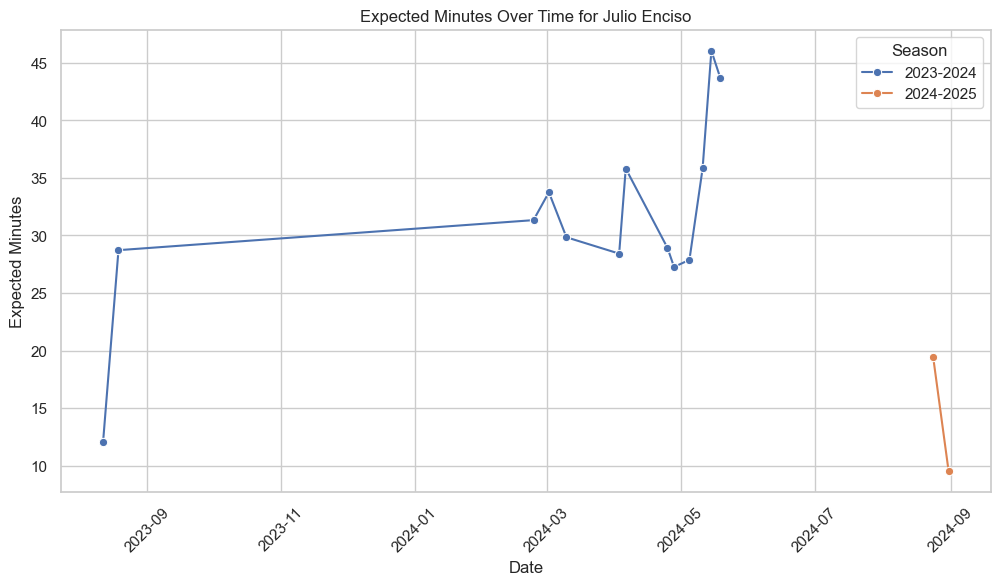

In [221]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Select a player by their Fbref ID
player_name = 'Julio Enciso'
player_data = fpl_players_match_logs[fpl_players_match_logs['Player'] == player_name]

# Plot Expected Minutes Over Time, grouped by Squad
plt.figure(figsize=(12, 6))
sns.lineplot(data=player_data, x='Date', y='Expected_Minutes', hue='Season', marker='o')
plt.title(f"Expected Minutes Over Time for {player_name}")
plt.xlabel("Date")
plt.ylabel("Expected Minutes")
plt.xticks(rotation=45)
plt.legend(title='Season')
plt.show()


In [239]:
fpl_players_match_logs.to_csv("C:\\Users\\erknud3\\fpl-optimization\\model\\data\\Historic_Data\\fpl_players_match_logs.csv", index=False)